In [1]:
from datetime import datetime
from geopy import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import matplotlib.pyplot as plt

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos
from skyfield.projections import build_stereographic_projection
import numpy as np

In [2]:
eph = load('de421.bsp') #load sun and earth position 

In [3]:
#load star data
with load.open(hipparcos.URL) as f:
    all_stars = hipparcos.load_dataframe(f)

In [12]:
#stars grouped into constellations
#graph based on polaris center (to label)
#graph baased on kaaifeng center (to find timing sweep)
    #save this info! 
    
sun = eph['sun']
earth = eph['earth']
moon = eph['moon']

In [5]:
def get_star_info(hip_number, t, projection):
    star = Star.from_dataframe(all_stars.loc[hip_number])
    star_pos = earth.at(t).observe(star)
    x, y = projection(star_pos)
    
    return star, x, y

In [6]:
def make_constellation(t, projection, *hip_numbers):
    
    stars = []
    stars_x = []
    stars_y = []
    
    for number in hip_numbers:
        star, x, y = get_star_info(number, t, projection)
        stars.append(star)
        stars_x.append(x)
        stars_y.append(y)
        
    return stars, stars_x, stars_y

In [7]:
constellations = {
    "northpole": [75097, 72607, 70692, 69112, 62561],
    "fourad" : [51384, 51502, 47193],
    "curvedarray": [77055,  82080, 85822,  11767,  5372, 113116],
    "greatemp": [109693]
}

In [15]:
def graph_chart(center, when, constellations): #time as string in NYC time
    
    #convert time....
    nyc_lat = 40.7128
    nyc_long = -74.006

    #turn time into proper string
    dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

    #convert time to UTC, from NYC
    timezone_str = tzwhere.tzwhere().tzNameAt(nyc_lat, nyc_long)
    local = timezone(timezone_str)
    local_dt = local.localize(dt, is_dst=None)
    utc_dt = local_dt.astimezone(utc)
    
    #time from utc converted 
    ts = load.timescale()
    t = ts.from_datetime(utc_dt)
    
    
    
    #define sun and earth position 
    sun = eph['sun']
    earth = eph['earth']
    moon = eph['moon']

    
    #define kaifeng location
    chart_lat = 34.795 #N
    chart_long = 114.345 #E
    
    #define observer at kaifeng 
    observer = wgs84.latlon(latitude_degrees=chart_lat, longitude_degrees=chart_long).at(t)
    position = observer.from_altaz(alt_degrees=90, az_degrees = 0)

    #find center
    if center == 'pol':
        center_object = Star.from_dataframe(all_stars.loc[11767])
        
    elif center == 'kaifeng':
        ra, dec, distance = observer.radec()
        center_object = Star(ra=ra, dec=dec)
        
    #do projection thing
    center = earth.at(t).observe(center_object)
    projection = build_stereographic_projection(center)
    field_of_view_degrees = 185.0
    
    #do moon and sun
    o = wgs84.latlon(latitude_degrees=chart_lat, longitude_degrees=chart_long)
    m_pos = (earth+o).at(t).observe(moon)
    s_pos = (earth+o).at(t).observe(sun)
    moonx, moony = projection(m_pos)
    sunx, suny = projection(s_pos)
    
    print(moonx, moony, sunx, suny)
    
    #figure out constellation positions 
    const_unpacked = []
    
    for const in constellations.keys():
        hips = constellations[const]
        stars, x, y = make_constellation(t, projection, hips)
        const_unpacked.append([stars, x, y])
   


    #draw figure...
    fig, ax = plt.subplots(figsize = (15, 15))
    border = plt.Circle((0, 0), 1, color = 'navy', fill=True)
    ax.add_patch(border)
    
    
    
    #plot constellations 
    for const in const_unpacked:
        ax.plot(const[1][0], const[2][0], "o-", color="white", markersize=5, linewidth=1, zorder=1)
                #markersize=5, color='white', marker='.', linestyle="-", linewidth=5)
    
    #plot sun and moon
    #ax.plot(sunx, suny, "o-", color="yellow", markersize= 10)
    #ax.plot(moonx, moony, "o-", color="red", markersize = 10)
    
    #clip horizon
    
    
    angle = np.pi - field_of_view_degrees / 360.0 * np.pi
    limit = np.sin(angle) / (1.0 - np.cos(angle))

    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_aspect(1.0)
    
    
    
    #horizon = plt.Circle((0, 0), radius = 1, transform = ax.transData)
    
    #for col in ax.collections:
    #    col.set_clip_path(horizon)
    
#     ax.set_xlim(-1, 1)
#     ax.set_ylim(-1, 1)
#     plt.axis('off')
    plt.show()
    
    return s_pos, m_pos

/Users/larkpie/mambaforge/lib/python3.9/site-packages/tzwhere/tzwhere.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.timezoneNamesToPolygons[tzname] = WRAP(polys)


-0.21700227751273407 1.109586798555052 1.1936931192612503 0.9680980212513276


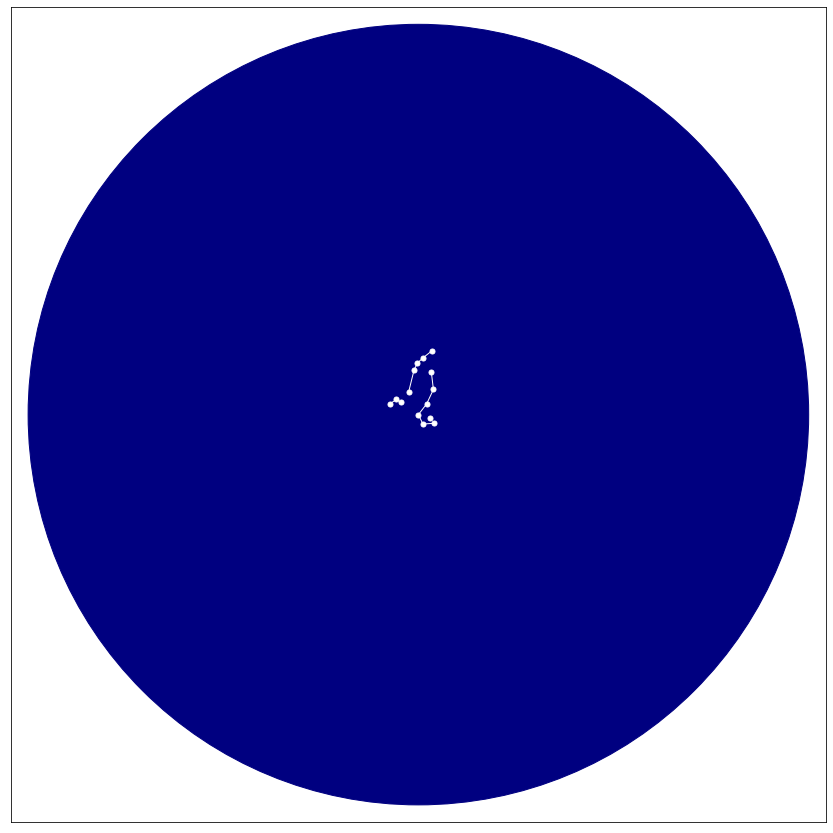

In [16]:
s = graph_chart("pol", "2000-12-20 03:50", constellations)

for key in constellations.keys():
    print(constellations[key])

In [112]:
#find position of polaris

pol, pol_x, pol_y = get_star_info(11767)

s2, s2_x, s2_y = get_star_info(85822)

s3, s3_x, s3_y = get_star_info(51914)

In [114]:
s3_y

0.01979809249413125

In [115]:
#charting
chart_size = 10
max_star_size = 100

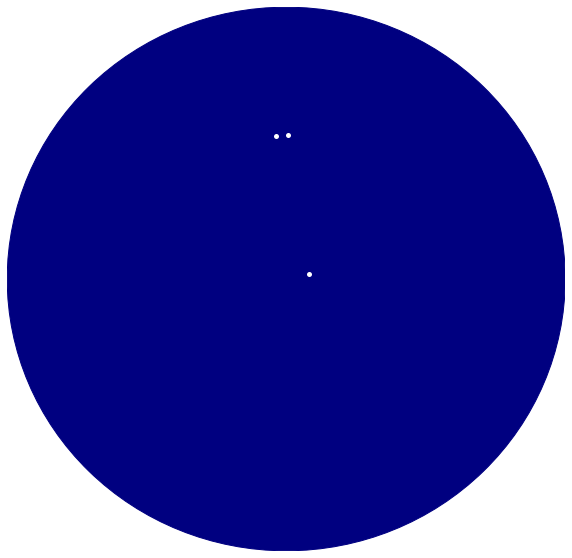

In [116]:
#plot
fig, ax = plt.subplots(figsize = (chart_size, chart_size))
border = plt.Circle((0,0), 1, color='navy', fill=True)
ax.add_patch(border)

#plot stars
#ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
          # s=marker_size, color='white', marker='.', linewidths=0,
          # zorder=2)
        
ax.scatter(pol_x, pol_y, s=100, color='white', marker='.', linewidths=0)
ax.scatter(s2_x, s2_y, s=100, color='white', marker='.', linewidths=0)
ax.scatter(s3_x, s3_y, s=100, color='white', marker='.', linewidths=0)

#cclip horizon
horizon = plt.Circle((0, 0), radius = 1, transform=ax.transData)
for col in ax.collections:
    col.set_clip_path(horizon)
    
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.axis('off')
plt.show()

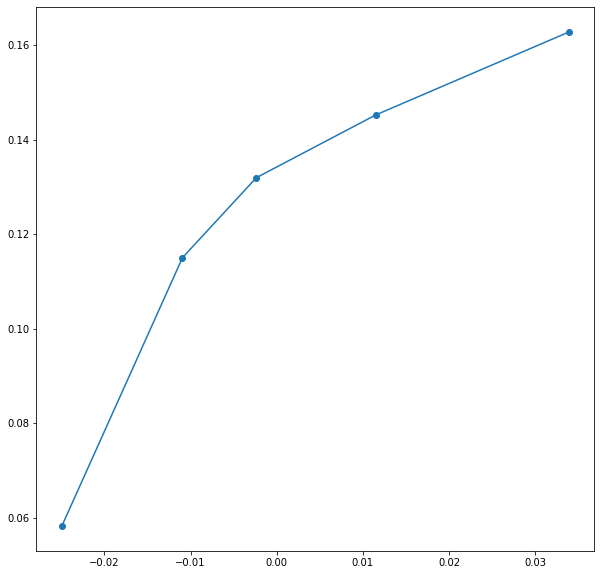

In [210]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(test[0][1][0], test[0][2][0], "o-")

In [209]:
test[0][2][0].tolist()

[0.16282119414142712,
 0.14523561878659924,
 0.13198458906270158,
 0.11505192346096502,
 0.05826220609773686]